## Scikit-Learn Clustering Experimentation

##### Date Created: 11/8/2020 

#### The purpose of this notebook is to develop experience with the datasets and clustering algorithms available in Scikit-Learn, relevant plotting with matplotlib, and synthetic data generation. The ultimate goal is to recreate some of the experiments conducted in:
Nathalie Barbosa Roa, Louise Travé-Massuyès, Victor Hugo Grisales. DyClee: Dynamic clustering for tracking evolving environments. Pattern Recognition, Elsevier, 2019, 94, pp.162-186. 10.1016/j.patcog.2019.05.024 . hal-02135580

#### PLEASE NOTE that the below is informed by Scikit-Learn documentation/definitions/examples (primarily the third link below), and the following book:
Aurelien Geron. Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems (Sebastopol, CA: O'Reilly Media, Inc., 2019).

### Useful links: 
- https://scikit-learn.org/stable/datasets/index.html#sample-generators
- https://scikit-learn.org/stable/modules/clustering.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html (Cluster comparison notebook)

### Imports 

In [1]:
from itertools import cycle, islice

import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, Birch
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.neighbors import kneighbors_graph

### Data 

#### Circles, Moons, Blobs, and Random datasets 

In [2]:
# Load and initialize data 

# As used in DyClee paper (page 18)
num_samples = 1500 

np.random.seed(0)

# sklearn.datasets.make_circles(n_samples=100, *, shuffle=True, noise=None,
# random_state=None, factor=0.8)
#X_circles, y_circles = make_circles(num_samples, factor=.5, noise=.05)
circles = make_circles(num_samples, factor=.5, noise=.05)


# sklearn.datasets.make_moons(n_samples=100, *, shuffle=True, noise=None,
# random_state=None)
#X_moon, y_moon = make_moons(num_samples, noise=.05)
moon = make_moons(num_samples, noise=.05)

# sklearn.datasets.make_blobs(n_samples=100, n_features=2, *, centers=None,
# cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None,
# return_centers=False)
#X_blobs, y_blobs = make_blobs(num_samples, random_state=8)
blobs = make_blobs(num_samples, random_state=8)

# Random data
#X_random, y_random = np.random.rand(num_samples, 2), np.zeros((num_samples, 1), dtype=np.uint8)
random_data = np.random.rand(num_samples, 2), np.zeros((num_samples, 1), dtype=np.uint8)

# Store all datasets into a list along with the specified number of clusters for each
datsets = [(circles, 2), (moon, 2), (blobs, 3), (random_data, 1)]

### Algorithms

#### MiniBatch-Kmeans
Instead of using the full dataset at each iteration like Kmeans, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution.

In [3]:
# @ X: dataset 
# @ num_clusters: number of clusters specified
def minibatch(X, num_clusters=3): 
    minibatch_kmeans = MiniBatchKMeans(n_clusters=num_clusters)
    minibatch_kmeans.fit(X)
    y_pred = minibatch_kmeans.predict(X)
    return y_pred

#### Agglomerative Clustering
At each iteration, agglomerative clustering connects the nearest pair of clusters (starting with individual instances). If you drew a tree with a branch for every pair of clusters that merged, you would get a binary tree of clusters, where the leaves are the individual instances.  It can capture clusters of various shapes, it produces a flexible and informative cluster tree instead of forcing you to choose a particular cluster scale, and it can be used with any pairwise distance.

In [4]:
# @ X: dataset 
# @ num_clusters: number of clusters specified
def AC(X, num_clusters=3): 
    
    # Connectivity matrix that indicates which pairs of instances are neighbors
    # This is needed to scale well on large datasets 
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    AC = AgglomerativeClustering(n_clusters=num_clusters, linkage="average", affinity="cityblock", connectivity=connectivity)
    y_pred = AC.fit_predict(X) 
    return y_pred

#### Affinity Propagation
This algorithm uses a voting system, where instances vote for similar instances to be their representatives, and once the algorithm converges, each representative and its voters form a cluster. Affinity propagation can detect any number of clusters of different sizes. Not suited for large datasets due to runtime being O(m^2). 

In [5]:
# @ X: dataset 
def AP(X): 
    AP = AffinityPropagation(damping=0.9, preference=-200, random_state=None)
    AP.fit(X)
    y_pred = AP.predict(X)
    return y_pred 

#### DBSCAN - (Density-Based Spatial Clustering of Applications with Noise)
This algorithm defines clusters as continuous regions of high density. 
It finds core samples of high density and expands clusters from them.
- For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s ε-neighborhood. 
- If an instance has at least min_samples instances in its ε-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions. 
- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

In [6]:
# @ X: dataset 
def db_scan(X):
    
    # @ eps: epsilon; 
    # The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    dbscan = DBSCAN(eps=0.2)
    y_pred = dbscan.fit_predict(X)
    return y_pred


#### Birch 
During training, it builds a tree structure containing just enough information to quickly assign each new instance to a cluster, without having to store all the instances in the tree: this approach allows it to use limited memory, while handling huge datasets.

In [7]:
# @ X: dataset 
# @ num_clusters: number of clusters specified
def birch_(X, num_clusters=3): 
    bir = Birch(n_clusters=num_clusters)
    y_pred = bir.fit_predict(X)
    return y_pred

### Plot datasets 

#### Function to plot clusters

In [8]:
# @ X : dataset 
# @ y_pred : predicted cluster 
# @ ax : plot graph 
# @ i : row number of plot
# @ j : column number of plot 
# Color code is used from cluster comparison notebook 
def plot_clusters(X, y_pred, ax, i, j): 
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                    '#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))
    
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[i,j].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

#### Calculate and plot clusters 

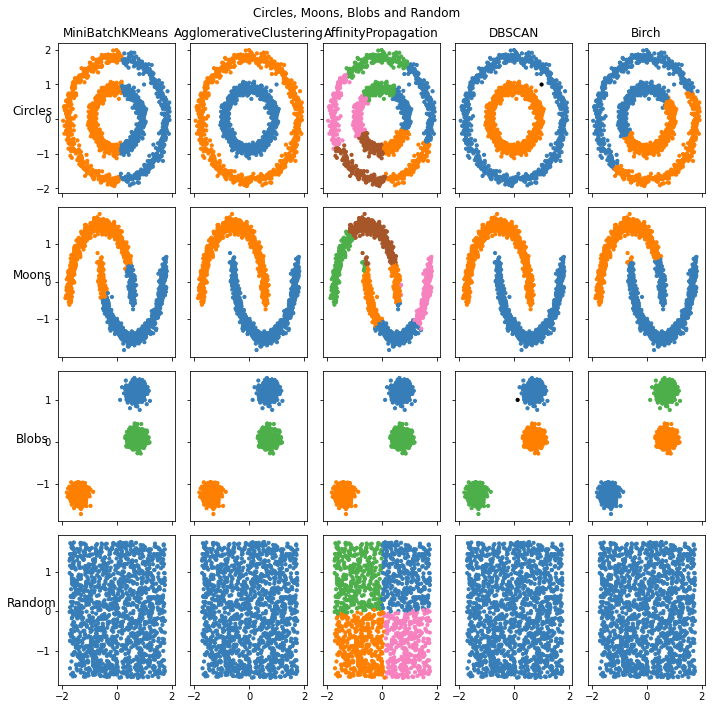

In [9]:
# Crate plot to hold all cluster plots 
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10,10))
fig.suptitle("Circles, Moons, Blobs and Random")

# Assign row and column labels for plot 
cols = ["MiniBatchKMeans", "AgglomerativeClustering", "AffinityPropagation", "DBSCAN", "Birch"]
rows = ["Circles", "Moons", "Blobs", "Random"]
for axes, col in zip(ax[0], cols): axes.set_title(col)
for axes, row in zip(ax[:,0], rows): axes.set_ylabel(row, rotation=0, size='large')

# list of algorithms  
algorithms = [minibatch, AC, AP, db_scan, birch_]

# list of algorithms that require a cluster input 
k_algo = [minibatch, AC, birch_]

# ignore warnings related to the kneighbors_graph in Agglomerative Clustering
# used from the cluster comparison notebook 
warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)

# Run all algorithms on each dataset, and plot the clustering 
for i, data in enumerate(datsets): 
    
    # get and standardize data 
    X = data[0][0]
    X = StandardScaler().fit_transform(X)

    # Cluster dataset on each algorithm 
    for j, algo in enumerate(algorithms): 
        
        # Provide number of clusters if algorithm requires it
        if algo in k_algo: 
            y_pred = algo(X, data[1])
        else: 
            y_pred = algo(X)
            
        # plot this cluster
        plot_clusters(X, y_pred, ax, i, j)
        
fig.tight_layout()